# Creating a network of AdEx neurons connected with synapses

In this notebook we first investigate parameter space of the AdEx neuron models, then select candidates for future pyramidal and interneuron parameter sets.

Next we create a network consisting of PCs and interneurons, which we connect by synapses with plasticity mechanisms. 

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
style.use(('ggplot','seaborn-muted'))

In [5]:
import pandas as pd

In [6]:
from brian2 import *

In [7]:
import input_factory as inpf

In [8]:
def beautify_spikes(statemon,spikemon,neuron_id):
    vm = statemon[neuron_id].v[:]
    offset = statemon.t[0]#/defaultclock.dt
    spike_times = spikemon.t[spikemon.i == neuron_id]
    for t in spike_times:
        i = int((t-offset) / defaultclock.dt)
        vm[i] = 20*mV
    return vm

## AdEx neuron

In [9]:
## Parameters that are shared by all neurons

# Neurons
Vth = -50*mV   # rheobase threshold
El = -70*mV     # resting membrane potential
Vcut = -20*mV    # spike detection threshold
deltaT = 2*mV  # spike initiation sharpness
Rin = 500*Mohm  # input resistance of a neuron at rest
gl = 1/Rin



# Synapses
E_e = 0*mV     # Excitatory synaptic reversal potential (AMPA and NMDA receptors)
E_i = -80*mV   # Inhibitory synaptic reversal potential (GABAA receptors)
tau_e = 5*ms   # time scale of excitatory synaptic conductance
tau_i = 10*ms  # time scale of excitatory synaptic conductance



AdEx_equations = Equations('''
dv/dt = (-(v-El) + deltaT*exp((v-Vth)/deltaT) + Rin*(Isyn + Ibias + Iapp - w))/tau_m : volt 
dw/dt = (a*(v-El) - w)/tau_w: amp  # adaptation variable
a : siemens
b : amp
tau_m : second
tau_w : second
Vreset: volt
stim_amp : 1
Ibias : amp
Iapp = stim_amp*input_current(t,i): amp
''')

# Synaptic input
synaptic_equations = Equations("""
Isyn =  - g_e*(v-E_e) - g_i*(v-E_i) : amp
dg_e/dt = -g_e/tau_e : siemens
dg_i/dt = -g_i/tau_i : siemens
""")

In [10]:
adex_params = pd.read_csv('adex_params.csv',index_col='type')
adex_params

,tau_m [ms],a [nS],tau_u [ms],b [pA],Vreset [mV]
type,,,,,
tonic,20.0,0.0,30,60,-55
adapting,200.0,0.0,100,5,-55
init. burst,5.0,0.5,100,7,-51
bursting,5.0,-0.5,100,7,-46
irregular,9.9,-0.5,100,7,-46
transient,10.0,1.0,100,10,-60
delayed,5.0,-1.0,100,10,-60


In [11]:
def convert_table_cell(col_name):
    units = col_name.split(' ')[1][1:-1]

def convert_from_table(row):
    return dict(
        a = float(row['a [nS]'])*nS,
        b = float(row['b [pA]'])*pA,
        tau_w = float(row['tau_u [ms]'])*ms,
        tau_m = float(row['tau_m [ms]'])*ms,
        Vreset = float(row['Vreset [mV]'])*mV,
        C = float(row['tau_m [ms]'])*ms*gl,
        Ibias = 0*pA
    )

In [12]:
tonic_pars = convert_from_table(adex_params.loc['tonic'])
adapting_pars = convert_from_table(adex_params.loc['adapting'])
bursting_pars = convert_from_table(adex_params.loc['bursting'])
initial_burst_pars = convert_from_table(adex_params.loc['init. burst'])
irregular_pars = convert_from_table(adex_params.loc['irregular'])
transient_pars = convert_from_table(adex_params.loc['transient'])
delayed_pars = convert_from_table(adex_params.loc['delayed'])

### Selecting exemplars of interneurons and PCs by Monte-Carlo

Here we create a group of 10^4 neurons with random parameter values. Next we select only neurons with admissible behavior. 

In [14]:
start_scope()

Nneurons = 10000

defaultclock.dt = 0.1*ms

G = NeuronGroup(Nneurons, AdEx_equations+synaptic_equations,threshold='v>Vcut', reset='v=Vreset; w += b',
                method='exponential_euler')

G.set_states(dict(v=El,w=0))

M = StateMonitor(G, ['v','w'], record=True)
S = SpikeMonitor(G,)

In [15]:
G.a = uniform(-1,3,Nneurons)*nsiemens
G.b = uniform(5,50,Nneurons)*pA
G.tau_m = uniform(5,200,Nneurons)*ms
G.tau_w = uniform(30,100,Nneurons)*ms
G.Vreset = uniform(-60,-45,Nneurons)*mV
G.Ibias = 'randn()*5*pA'

# G.a = -0.5*nS
# G.b = 7*pA
# G.tau_m = 5*ms
# G.tau_w = 100*ms
# G.Vreset = -46*mV

In [16]:
input_current = inpf.get_step_current(1000, 2000, 1*ms, 1.0*pA,Nneurons=Nneurons)

In [17]:
store()

In [18]:
restore()
G.stim_amp = 100
%time run(5*second)

CPU times: user 41.1 s, sys: 4.04 s, total: 45.1 s
Wall time: 47.6 s


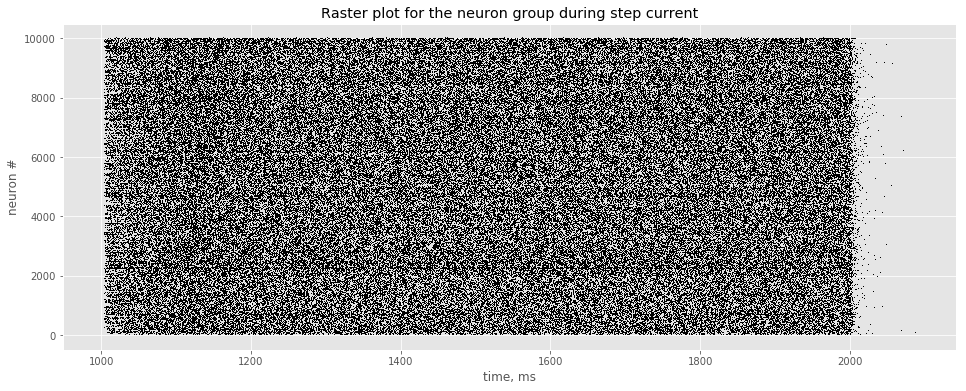

In [20]:
figure(figsize=(16,6))
plot(S.t/ms, S.i, 'k,',lw=0.5)
xlabel('time, ms')
ylabel('neuron #')
title('Raster plot for the neuron group during step current')

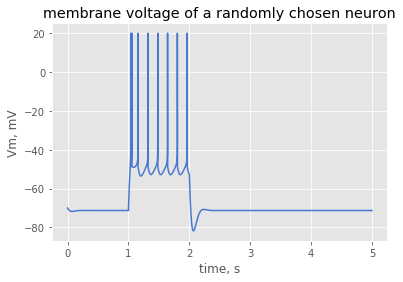

In [21]:
k = randint(Nneurons)
plot(M.t, beautify_spikes(M,S,k)/mV)
xlabel('time, s')
ylabel('Vm, mV')
title('membrane voltage of a randomly chosen neuron')

In [22]:
array([1/mean(diff((S.t[S.i==k])))])

array([ 7.56511402])

In [23]:
def validate_neurons(statemon,spikes,
                     min_spiking_rate = 5*Hz,
                     max_spiking_rate = 300*Hz,
                     reject_restless_prob=0.5):
    N = len(statemon.v)
    invalid = any(abs(statemon.v[:,:])>200*mV,axis=1) + isnan(statemon.v.sum(1))
    late_spikes = array([any(spikes.t[spikes.i==i]>3*second) for i in range(N)])
    
    rates = array([1/mean(diff(spikes.t[spikes.i==i]))/second if len(spikes.t[spikes.i==i])>2 else 0*Hz 
                   for i in range(N)])/second
    invalid += (rates < min_spiking_rate)
    invalid += (rates > max_spiking_rate)
    invalid += (late_spikes)&(rand(N)<reject_restless_prob)
    return ~invalid
    

In [24]:
%time valid = validate_neurons(M,S)
print(sum(valid)/Nneurons)

CPU times: user 7.73 s, sys: 12.3 s, total: 20 s
Wall time: 1min 56s
0.9148


In [25]:
k = where(valid)[0][randint(sum(valid))]

In [26]:
k,valid[k]

(8001, True)

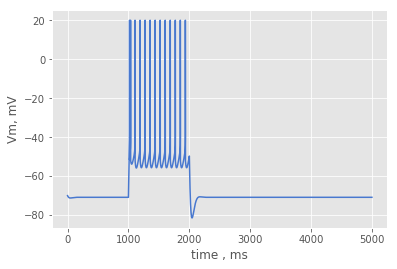

In [27]:
figure()
plot(M.t/ms,beautify_spikes(M,S,k)/mV)
xlabel('time , ms')
ylabel('Vm, mV')

In [28]:
def is_good_interneuron(statemon,spikes,k,min_rate=50*Hz,min_omega=5*Hz):
    rate = 1/mean(diff(spikes.t[spikes.i==k])) if len(spikes.t[spikes.i==k])>2 else 0*Hz
    aR = G.a[k]*Rin
    tautau = G.tau_m[k]/G.tau_w[k]
    omega = 4*(aR - 2*(1-tautau**2)/tautau)/G.tau_w[k]
    return(rate>min_rate) and (omega>0.5*min_rate)

def is_good_pyramidal(statemon,spikes,k,max_rate=25*Hz):
    rate = 1/mean(diff(spikes.t[spikes.i==k])) if len(spikes.t[spikes.i==k])>2 else 0*Hz
    aR = G.a[k]*Rin
    tautau = G.tau_m[k]/G.tau_w[k]
    omega = 4*(aR - 2*(1-tautau**2)/tautau)/G.tau_w[k]
    return(rate<=max_rate) and (omega <= 0)

In [29]:
%time interneurons = array([is_good_interneuron(M,S,k) for k in range(Nneurons)])

CPU times: user 3.74 s, sys: 56.1 ms, total: 3.8 s
Wall time: 3.83 s


In [30]:
%time pyramidals = array([is_good_pyramidal(M,S,k) for k in range(Nneurons)])

CPU times: user 3.91 s, sys: 49.8 ms, total: 3.96 s
Wall time: 3.97 s


In [31]:
acc = zeros((Nneurons,2))
for k in range(Nneurons):
    if valid[k]:
        aR = G.a[k]*Rin
        tautau = G.tau_m[k]/G.tau_w[k]
        acc[k] = tautau,aR


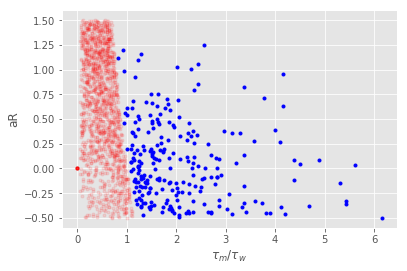

In [32]:
plot(acc[interneurons][:,0],acc[interneurons][:,1],'b.')
plot(acc[pyramidals][:,0],acc[pyramidals][:,1],'r.',alpha=0.1)
xlabel('$\\tau_m/\\tau_w$')
ylabel('aR')

In [33]:
sum(interneurons)/Nneurons, sum(pyramidals)/Nneurons

(0.023699999999999999, 0.15049999999999999)

In [34]:
interneuron_pars = dict(a=G.a[interneurons], b=G.b[interneurons],
                        tau_w=G.tau_w[interneurons],tau_m=G.tau_m[interneurons],
                        Ibias=G.Ibias[interneurons],
                        Vreset = G.Vreset[interneurons])
pyramidal_pars = dict(a=G.a[pyramidals], b=G.b[pyramidals],
                        tau_w=G.tau_w[pyramidals],tau_m=G.tau_m[pyramidals],
                        Ibias = G.Ibias[pyramidals],
                        Vreset = G.Vreset[pyramidals])

In [35]:
len(interneuron_pars['a'])

237

In [36]:
def sample_from_class(parameters,sigma=0.01):
    N = len(parameters['a'])
    k = randint(N)
    multipliers = 1 + sigma*randn(10)
    return dict(a = parameters['a'][k]*multipliers[0],
                b = parameters['b'][k]*multipliers[1],
                tau_m = parameters['tau_m'][k]*multipliers[2],
                tau_w = parameters['tau_w'][k]*multipliers[3],
                Vreset = parameters['Vreset'][k]*multipliers[4],
                Ibias = parameters['Ibias'][k]*multipliers[5]
               )


In [37]:
def update_neuron_parameters(neurons, k, pars):
    neurons.a[k] = pars['a']
    neurons.b[k] = pars['b']
    neurons.tau_m[k] = pars['tau_m']
    neurons.tau_w[k] = pars['tau_w']
    neurons.Vreset[k] = pars['Vreset']
    neurons.Ibias[k] = pars['Ibias']

In [38]:
def raster_spikes(spikemon,Nexc=None,ax=None,colors='rb'):
    if ax is None:
        f,ax = subplots(1,1)
    if Nexc is None:
        Nexc = max(spikemon.i)
    exc_spikes = spikemon.i<Nexc
    if any(exc_spikes):
        ax.plot(spikemon.t[exc_spikes]/ms, spikemon.i[exc_spikes],',',c=colors[0])
    if any(~exc_spikes):
        ax.plot(spikemon.t[~exc_spikes]/ms, spikemon.i[~exc_spikes],',',c=colors[1])

Here we create a source of "natural" drive to our future network in form of Poisson spike trains from 100 neurons

In [42]:
start_scope()
P = PoissonGroup(100,  'rand()*25*Hz')
Sp = SpikeMonitor(P)

In [43]:
run(5*second)

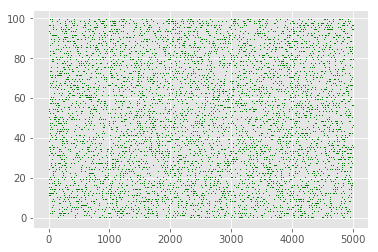

In [44]:
raster_spikes(Sp,100,colors='gg')

## Now create a new network with 80% pyramidal cells and 20% interneurons

Below we will create a model network with many principal (excitatory) neurons and a smaller amount of interneurons (inhibitory). A random subset of principal neurons will receive "sensory" input in form of Poisson spike trains.

Neurons within the network will be connected with synapses havin both short-time plasticity (Tsodyks & Markram model) and spike-timing dependent plasticity (STDP).

In [266]:
seed(4022)

In [267]:
start_scope()


Ninh = 1000
Nexc = 4*Ninh


Nneurons = Nexc + Ninh

defaultclock.dt = 0.1*ms

G = NeuronGroup(Nneurons, AdEx_equations+synaptic_equations,threshold='v>Vcut', reset='v=Vreset; w += b',
                method='exponential_euler')

G.set_states(dict(v=El,w=0))

M = StateMonitor(G, ['v','w','g_e','g_i'], record=True)
S = SpikeMonitor(G,)

In [268]:
for k in range(Nneurons):
    exemplar_parameters = pyramidal_pars if k < Nexc else interneuron_pars
    #exemplar_parameters = pyramidal_pars# if k < Nexc else interneuron_pars
    sigma = 0.05 if k < Nexc else 0.01
    p = sample_from_class(exemplar_parameters,sigma)
    update_neuron_parameters(G,k,adapting_pars)

In [269]:
P = PoissonGroup(100,  'rand()*25*Hz')
Sp = SpikeMonitor(P)

### Setting up synaptic connections

In [270]:
tau_ps = 0.8*second   # facilitation timescale
tau_ns = 1.5*second   # replenishing timescale
tau_stdp = 20*ms     # STDP time constant

p_s0 = 0.6            # ground-state probability of release
epsilon = 0.05        # sparsity synaptic connectivity

Apre0 = 0.01
Apost0 = -Apre0*1.05

w_e = 20*0.05*nS
w_i = 20*1*nS

stdp_value = 0 # change between 0 and 1

tm_plasticity_model = Equations('''
dp_s/dt = (p_s0-p_s)/tau_ps : 1 (event-driven)    # release probability
dn_s/dt = (1-n_s)/tau_ns   : 1    (event-driven)    # fraction of resources available
''')

stdp_model=Equations('''
dApre/dt = -Apre/tau_stdp : 1 (event-driven)    # STDP
dApost/dt = -Apost/tau_stdp : 1(event-driven)   # STDP
w_syn: 1
''')

plasticity_action_pre='''
p_s += p_s0*(1-p_s) # facilitation
r_s = p_s*n_s       # probability of release
n_s -= r_s          # depletion
'''

stdp_action_pre='''
Apre += Apre0
'''

stdp_action_post='''
Apost += Apost0
'''


pre_actions_e = '''
w_syn = clip(w_syn+Apost, (1-stdp_value)*w_e/nS, w_e/nS) 
g_e_post += w_syn*r_s*nS
'''
pre_actions_i = '''
w_syn = clip(w_syn+Apost, (1-stdp_value)*w_i/nS, w_i/nS) 
g_i_post += w_syn*r_s*nS
'''

post_actions_e='''
w_syn = clip(w_syn+Apre,(1-stdp_value)*w_e/nS,w_e/nS)
'''

post_actions_i='''
w_syn = clip(w_syn+Apre,(1-stdp_value)*w_i/nS,w_i/nS)
'''

In [271]:
S_exc = Synapses(G[:Nexc],G, model=tm_plasticity_model+stdp_model,
                 on_pre=plasticity_action_pre+stdp_action_pre+pre_actions_e,
                 on_post=stdp_action_post+post_actions_e)

                
S_inh = Synapses(G[Nexc:],G, model=tm_plasticity_model+stdp_model,
                 on_pre=plasticity_action_pre+stdp_action_pre+pre_actions_i,
                 on_post=stdp_action_post+post_actions_i)


S_input = Synapses(P,G[:Nexc],model=tm_plasticity_model,
                 on_pre=plasticity_action_pre+'g_e_post += 10*w_e*r_s')

In [272]:
%%time 

S_input.connect(p=0.1)

S_exc.connect(p=epsilon)
S_exc.delay = '10*ms + 0.1*randn()*ms'

S_inh.connect(p=2*epsilon)
S_inh.delay = '10*ms + 0.1*randn()*ms'

CPU times: user 291 ms, sys: 7.89 ms, total: 299 ms
Wall time: 301 ms


In [273]:
S_input.active=True
S_exc.active=False
S_inh.active=False

In [274]:
net = Network(G,P,M,S,Sp,S_exc,S_inh,S_input)

In [275]:
net.store()

In [276]:
input_current = inpf.get_step_current(1000, 6000, 1*ms, 1.0*pA,Nneurons=Nneurons)

In [277]:
net.restore()
S_input.active=True
S_exc.active=False
S_inh.active=False
G.stim_amp = 25

In [279]:
%time net.run(10*second,report='text')

Starting simulation at t=0. s for a duration of 10. s
1.6385 s (16%) simulated in 10s, estimated 52s remaining.
3.2769 s (32%) simulated in 20s, estimated 43s remaining.
5.276 s (52%) simulated in 30s, estimated 28s remaining.
6.5537 s (65%) simulated in 56s, estimated 30s remaining.
8.326 s (83%) simulated in 1m 10s, estimated 14s remaining.
9.2066 s (92%) simulated in 1m 20s, estimated 7s remaining.
9.599 s (95%) simulated in 1m 31s, estimated 4s remaining.
10. s (100%) simulated in 1m 36s
CPU times: user 51.6 s, sys: 10.8 s, total: 1min 2s
Wall time: 1min 37s


In [280]:
%time valid = validate_neurons(M,S)
print(sum(valid)/Nneurons)

CPU times: user 4.72 s, sys: 10.7 s, total: 15.4 s
Wall time: 3min 21s
0.0006


(0.0, 9999.9)

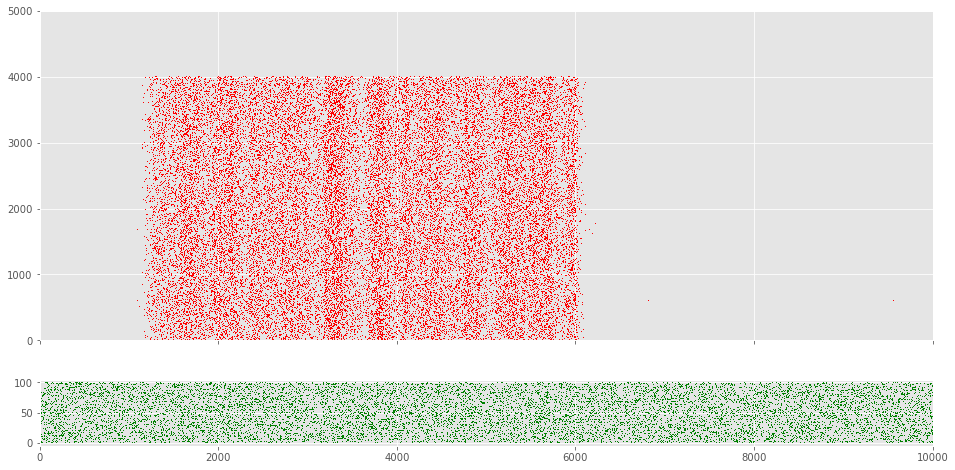

In [281]:
f,axs = subplots(2,1,sharex=True,figsize=(16,8),gridspec_kw=dict(height_ratios=(5,1)))
raster_spikes(S,Nexc,axs[0])
axs[0].set_ylim(0,Nneurons)
raster_spikes(Sp,100,axs[1],colors='gg')
xlim(M.t[0]/ms,M.t[-1]/ms)

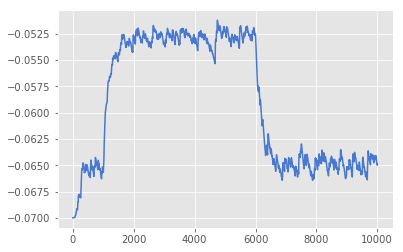

In [282]:
k = randint(Nexc)
plot(M.t/ms, beautify_spikes(M,S,k))

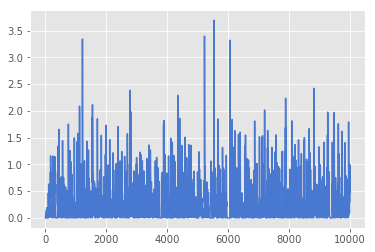

In [283]:
k = randint(Nexc)
plot(M.t/ms, M.g_e[k]/nS)

### Turn on the synapses

In [284]:
net.restore()
stdp_value = 0.5 # change between 0 and 1

In [285]:
S_exc.active=True
S_inh.active=True

In [286]:
G.stim_amp = 25

%time net.run(10*second,report='text')

Starting simulation at t=0. s for a duration of 10. s
0.6748 s (6%) simulated in 10s, estimated 2m 18s remaining.
1.2948 s (12%) simulated in 20s, estimated 2m 14s remaining.
1.8155 s (18%) simulated in 30s, estimated 2m 15s remaining.
2.34 s (23%) simulated in 40s, estimated 2m 11s remaining.
2.9503 s (29%) simulated in 50s, estimated 1m 59s remaining.
3.5314 s (35%) simulated in 1m 0s, estimated 1m 50s remaining.
4.0096 s (40%) simulated in 1m 10s, estimated 1m 45s remaining.
4.5448 s (45%) simulated in 1m 20s, estimated 1m 36s remaining.
4.781 s (47%) simulated in 1m 30s, estimated 1m 39s remaining.
5.0509 s (50%) simulated in 1m 40s, estimated 1m 38s remaining.
5.362 s (53%) simulated in 1m 50s, estimated 1m 36s remaining.
5.6521 s (56%) simulated in 2m 0s, estimated 1m 33s remaining.
5.8747 s (58%) simulated in 2m 10s, estimated 1m 32s remaining.
6.157 s (61%) simulated in 2m 20s, estimated 1m 28s remaining.
6.4554 s (64%) simulated in 2m 30s, estimated 1m 23s remaining.
6.6988 s 

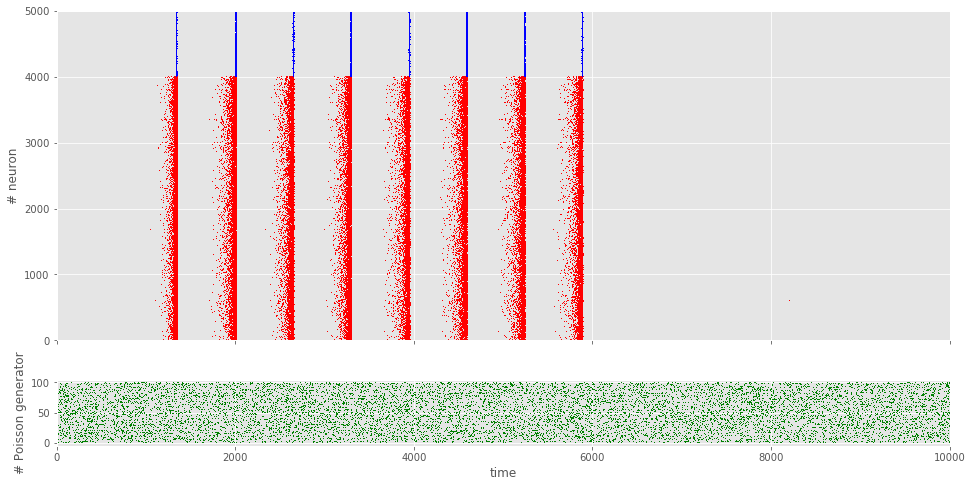

In [287]:
f,axs = subplots(2,1,sharex=True,figsize=(16,8),gridspec_kw=dict(height_ratios=(5,1)))

raster_spikes(S,Nexc,axs[0])
raster_spikes(Sp,100,axs[1],colors='gg')

axs[0].set_ylim(0,Nneurons)

xlim(M.t[0]/ms,M.t[-1]/ms)
axs[0].set_ylabel('# neuron')
xlabel('time')
ylabel('# Poisson generator')

4619


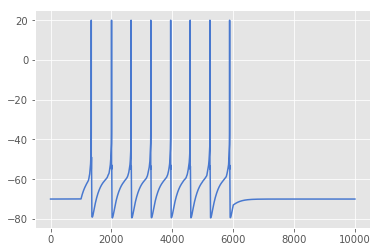

In [288]:
k = randint(Ninh)+Nexc
print(k)
plot(M.t/ms, beautify_spikes(M,S,k)/mV)

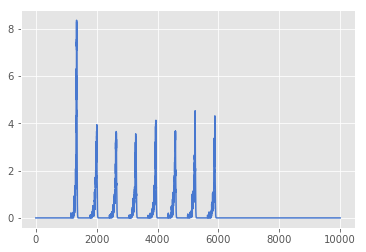

In [289]:
plot(M.t/ms, M.g_e[k]/nS)